>>> Training PG (Algo 1)...
501th epoch LSTM-DPO loss:  -2.0958901641423973
1001th epoch LSTM-DPO loss:  -2.0849707790753955
1501th epoch LSTM-DPO loss:  -2.079600391380336
2001th epoch LSTM-DPO loss:  -2.0964322389736756
>>> Computing PGDPO (Algo 2)...
>>> Training FABSDE (Algo 3)...
501th epoch Deep ABSDE loss:  0.004311677865983413
1001th epoch Deep ABSDE loss:  0.0007136891990464508
1501th epoch Deep ABSDE loss:  0.00012042293357704056
2001th epoch Deep ABSDE loss:  5.363426302475887e-05
2501th epoch Deep ABSDE loss:  4.2650125324471415e-05
3001th epoch Deep ABSDE loss:  3.6644344080205344e-05
3501th epoch Deep ABSDE loss:  3.239703624109374e-05
4001th epoch Deep ABSDE loss:  3.0990824279502814e-05
4501th epoch Deep ABSDE loss:  2.813941626892517e-05
5001th epoch Deep ABSDE loss:  3.2326449730477334e-05
5501th epoch Deep ABSDE loss:  2.5458345702066802e-05
6001th epoch Deep ABSDE loss:  2.5553205355119496e-05
6501th epoch Deep ABSDE loss:  2.5299077203977755e-05
7001th epoch Deep A

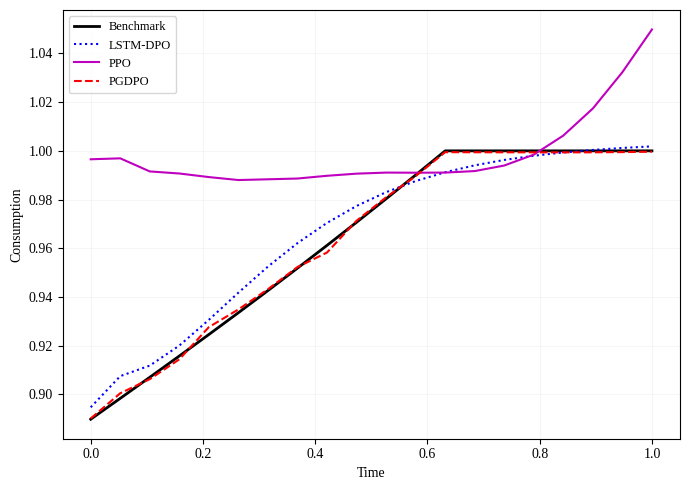

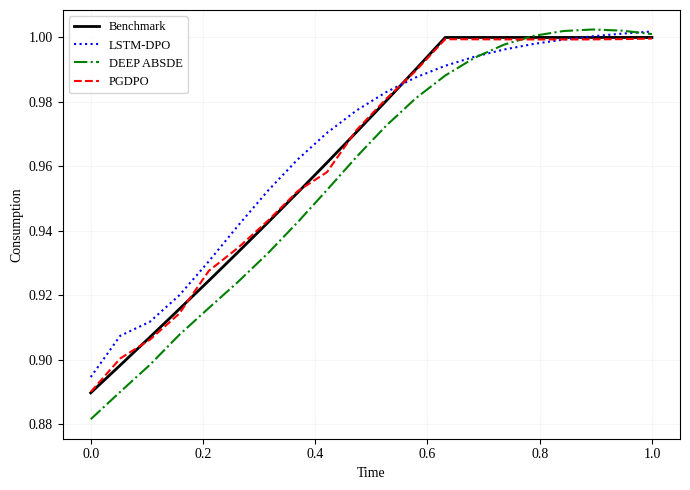

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams.update({
    "pdf.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Liberation Serif", "FreeSerif", "serif"],
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "mathtext.fontset": "stix",
})

# =============================================================================
# 0. Unified Configuration
# =============================================================================
CFG = {
    # reproducibility / device / dtype
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "dtype": torch.float64,

    # problem params
    "alpha": 0.1,
    "beta": 0.2,
    "gamma": 0.5,
    "k_terminal": 1.0,
    "T": 1.0,
    "N": 20,
    "delta": 0.4,
    "X0": 1.0,

    # training params (shared)
    "train_paths": 256,
    "hidden": 64,
    "lr": 3e-4,
    "lr_ppo": 5e-4,

    # iterations
    "n_iters": 2000,
    "fabsde_iters": 7000,
    "ppo_episodes": 2000,   # # of updates. Not the number of total episodes
    "ppo_epochs": 5,
    "ppo_batch": 512,
}

DEVICE = torch.device(CFG["device"])
torch.set_default_dtype(CFG["dtype"])


def set_seed(seed: int) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


# =============================================================================
# 1. Physics (Dynamics / Utility)
# =============================================================================
class Physics:
    """Shared physics dynamics and utilities."""

    def __init__(self, cfg: dict):
        self.alpha = cfg["alpha"]
        self.beta = cfg["beta"]
        self.gamma = cfg["gamma"]
        self.k_term = cfg["k_terminal"]

        self.h = cfg["T"] / cfg["N"]
        self.delay_steps = int(round(cfg["delta"] / self.h))

    def step(self, x_now, x_lag, u, dW):
        drift = self.alpha * x_lag - u
        diff = self.beta * x_lag
        return x_now + drift * self.h + diff * dW

    def utility(self, u):
        return (u ** self.gamma) / self.gamma

    def get_terminal_reward(self, x_final):
        return self.k_term * x_final

    def init_history(self, batch_size: int, x0: float):
        return [
            torch.full((batch_size,), x0, device=DEVICE)
            for _ in range(self.delay_steps + 1)
        ]


# =============================================================================
# 2. Models
# =============================================================================
class BaseLSTM(nn.Module):
    def __init__(self, output_dim: int, hidden_dim: int):
        super().__init__()
        self.lstm = nn.LSTM(3, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x, x_lag, hidden):
        inp = torch.stack([t, x, x_lag], dim=1).unsqueeze(1)  # (B,1,3)
        out, new_hidden = self.lstm(inp, hidden)
        return self.fc(out[:, -1, :]), new_hidden


class PolicyNet(BaseLSTM):
    def __init__(self):
        super().__init__(output_dim=1, hidden_dim=CFG["hidden"])

    def forward(self, t, x, x_lag, hidden):
        raw, h_new = super().forward(t, x, x_lag, hidden)
        return torch.nn.functional.softplus(raw).squeeze(-1), h_new


class FABSDE_Net(BaseLSTM):
    def __init__(self):
        super().__init__(output_dim=4, hidden_dim=CFG["hidden"])  # Y, Z, EY, EZ

    def forward(self, t, x, x_lag, hidden):
        raw, new_hidden = super().forward(t, x, x_lag, hidden)
        Y = torch.nn.functional.softplus(raw[:, 0]) + 1e-6
        Z = raw[:, 1]
        EY = torch.nn.functional.softplus(raw[:, 2]) + 1e-6
        EZ = raw[:, 3]
        return Y, Z, EY, EZ, new_hidden


class WindowConsumptionPPO(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, window_size=10):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.actor_mu = nn.Linear(hidden_dim, 1)
        self.actor_log_std = nn.Parameter(torch.zeros(1) - 0.5)
        self.critic = nn.Linear(hidden_dim, 1)
        nn.init.constant_(self.actor_mu.bias, 0.0)

    def forward(self, obs_seq):
        out, _ = self.lstm(obs_seq)
        last_hidden = out[:, -1, :]
        mu = self.actor_mu(last_hidden)
        val = self.critic(last_hidden)
        std = torch.exp(self.actor_log_std).expand_as(mu)
        return mu, std, val

    def get_action(self, obs_seq, deterministic=False):
        mu, std, val = self.forward(obs_seq)

        if deterministic:
            raw = mu
            c = torch.nn.functional.softplus(raw) + 1e-6
            return c, val

        dist = torch.distributions.Normal(mu, std)
        raw = dist.sample()
        c = torch.nn.functional.softplus(raw) + 1e-6
        log_prob = dist.log_prob(raw)
        return c, log_prob, val, raw

# =============================================================================
# 3. Benchmark Solvers
# =============================================================================
def solve_analytic():
    phy = Physics(CFG)
    p = np.zeros(CFG["N"] + 1)
    p[CFG["N"] - phy.delay_steps:] = CFG["k_terminal"]

    for i in range(CFG["N"] - phy.delay_steps - 1, -1, -1):
        p[i] = p[i + 1] + CFG["alpha"] * phy.h * p[i + 1 + phy.delay_steps]

    c_star = np.maximum(p, 1e-12) ** (1.0 / (CFG["gamma"] - 1.0))
    return c_star, p


def train_pg(policy: nn.Module, phy: Physics):
    print(">>> Training PG (Algo 1)...")
    opt = optim.Adam(policy.parameters(), lr=CFG["lr"])

    for it in range(1, CFG["n_iters"] + 1):
        opt.zero_grad()

        dW = torch.randn(CFG["train_paths"], CFG["N"], device=DEVICE) * np.sqrt(phy.h)
        X = torch.zeros(CFG["train_paths"], CFG["N"] + phy.delay_steps + 1, device=DEVICE)
        X[:, : phy.delay_steps + 1] = CFG["X0"]

        run_util = 0.0
        hidden = None

        for n in range(CFG["N"]):
            k = phy.delay_steps + n
            t_val = torch.full((CFG["train_paths"],), n * phy.h, device=DEVICE)
            c_n, hidden = policy(t_val, X[:, k], X[:, n], hidden)
            X[:, k + 1] = phy.step(X[:, k], X[:, n], c_n, dW[:, n])
            run_util += phy.utility(c_n) * phy.h

        loss = -(run_util + phy.get_terminal_reward(X[:, -1])).mean()
        if it % 500 == 0:
            print(f"{it+1}th epoch LSTM-DPO loss: ", loss.item())
        loss.backward()
        opt.step()

    return policy


def compute_ppgdpo(base_policy: nn.Module, phy: Physics):
    print(">>> Computing PGDPO (Algo 2)...")
    c_proj, p_proj = [], []

    real_hist = [torch.tensor([CFG["X0"]], device=DEVICE) for _ in range(phy.delay_steps + 1)]

    for i in range(CFG["N"]):
        x_start = real_hist[-1].detach().clone().requires_grad_(True)
        n_inner = 8192

        past_hist = torch.stack(real_hist[:-1]).detach().expand(-1, n_inner)
        curr_state = x_start.expand(n_inner)
        inner_X = [past_hist[k] for k in range(phy.delay_steps)] + [curr_state]

        hidden_inner = None
        J_future = 0.0

        for step in range(CFG["N"] - i):
            abs_step = i + step
            k_idx = phy.delay_steps + step
            t_val = torch.full((n_inner,), abs_step * phy.h, device=DEVICE)

            x_now, x_lag = inner_X[k_idx], inner_X[step]
            c_val, hidden_inner = base_policy(t_val, x_now, x_lag, hidden_inner)

            dW = torch.randn(n_inner, device=DEVICE) * np.sqrt(phy.h)
            x_next = phy.step(x_now, x_lag, c_val, dW)
            inner_X.append(x_next)
            J_future += phy.utility(c_val) * phy.h

        J_total = J_future + phy.get_terminal_reward(inner_X[-1])
        grads = torch.autograd.grad(J_total.sum(), x_start)
        p_t = grads[0].item() / n_inner

        p_clamped = max(p_t, 1e-12)
        c_star = p_clamped ** (1.0 / (CFG["gamma"] - 1.0))

        c_proj.append(c_star)
        p_proj.append(p_t)

        x_next_real = phy.step(
            real_hist[-1],
            real_hist[-(phy.delay_steps + 1)],
            torch.tensor([c_star], device=DEVICE),
            0.0,
        )
        real_hist.append(x_next_real)

    return np.array(c_proj), np.array(p_proj)


def train_fabsde(phy: Physics):
    print(">>> Training FABSDE (Algo 3)...")
    net = FABSDE_Net().to(DEVICE)
    opt = optim.Adam(net.parameters(), lr=CFG["lr"])

    for it in range(1, CFG["fabsde_iters"] + 1):
        opt.zero_grad()

        B = CFG["train_paths"]
        dW = torch.randn(B, CFG["N"], device=DEVICE) * np.sqrt(phy.h)
        X = phy.init_history(B, CFG["X0"])

        preds = {"Y": [], "Z": [], "EY": [], "EZ": []}
        tildeY = [None] * (CFG["N"] + 1)
        hidden = None

        for i in range(CFG["N"]):
            k = phy.delay_steps + i
            t_i = torch.full((B,), i * phy.h, device=DEVICE)

            Y, Z, EY, EZ, hidden = net(t_i, X[k], X[i], hidden)
            preds["Y"].append(Y)
            preds["Z"].append(Z)
            preds["EY"].append(EY)
            preds["EZ"].append(EZ)

            c_i = Y.pow(1.0 / (CFG["gamma"] - 1.0))
            X.append(phy.step(X[k], X[i], c_i, dW[:, i]))

            f_i = (CFG["alpha"] * EY + CFG["beta"] * EZ) if i <= CFG["N"] - phy.delay_steps else torch.zeros_like(Y)
            tildeY[i + 1] = Y - f_i * phy.h + Z * dW[:, i]

        t_N = torch.full((B,), CFG["N"] * phy.h, device=DEVICE)
        Y_N, Z_N, EY_N, EZ_N, _ = net(t_N, X[-1], X[CFG["N"]], hidden)
        preds["Y"].append(Y_N)
        preds["Z"].append(Z_N)
        preds["EY"].append(EY_N)
        preds["EZ"].append(EZ_N)

        L1 = sum((preds["Y"][i + 1] - tildeY[i + 1]).pow(2).mean() for i in range(CFG["N"]))
        L1 += (preds["Y"][CFG["N"]] - CFG["k_terminal"]).pow(2).mean()

        L2 = 0.0
        if phy.delay_steps <= CFG["N"]:
            limit = CFG["N"] - phy.delay_steps
            L2 += sum((preds["EY"][i] - tildeY[i + phy.delay_steps]).pow(2).mean() for i in range(limit + 1))
            L2 += sum((preds["EZ"][i] - preds["Z"][i + phy.delay_steps]).pow(2).mean() for i in range(limit + 1))

        (L1 + L2).backward()

        if it % 500 == 0:
            print(f"{it+1}th epoch Deep ABSDE loss: ", (L1+L2).item())
        opt.step()

    with torch.no_grad():
        c_path, Y_path = [], []
        hidden = None
        X = phy.init_history(1, CFG["X0"])

        for i in range(CFG["N"]):
            k = phy.delay_steps + i
            res = net(torch.tensor([i * phy.h], device=DEVICE), X[k], X[i], hidden)
            hidden = res[-1]
            c_val = res[0].pow(1.0 / (CFG["gamma"] - 1.0))
            c_path.append(c_val.item())
            Y_path.append(res[0].item())
            X.append(phy.step(X[k], X[i], c_val, 0.0))

    return np.array(c_path), np.array(Y_path)


# =============================================================================
# PPO (Algo 4)
# =============================================================================
def train_ppo(phy: Physics):
    print(">>> Training PPO (Algo 4) [STANDARD PPO + (B) obs: history(old->new)+t_norm]...")

    device = DEVICE
    dt = float(phy.h)
    delay_steps = int(phy.delay_steps)

    H = delay_steps + 1

    B = int(CFG["train_paths"])      # parallel envs
    T = int(CFG["N"])               # rollout length
    ppo_epochs = int(CFG["ppo_epochs"])
    minibatch_size = int(CFG["ppo_batch"])

    gamma_rl = 1.0
    lam_gae = 0.95
    clip_eps = 0.2
    ent_coef = 0.01
    vf_coef = 0.5
    max_grad_norm = 0.5

    x_norm = float(CFG.get("ppo_x_norm", 1.0))
    x0 = float(CFG["X0"])
    T_horizon = float(CFG["T"])

    agent = WindowConsumptionPPO(input_dim=2, hidden_dim=CFG["hidden"], window_size=H).to(device).float()
    optimizer = optim.Adam(agent.parameters(), lr=float(CFG["lr_ppo"]))

    Obs_buf = torch.empty((T, B, H, 2), device=device, dtype=torch.float32)  # (x_hist_seq, t_norm)
    A_buf   = torch.empty((T, B, 1),    device=device, dtype=torch.float32)  # raw action
    LP_buf  = torch.empty((T, B),       device=device, dtype=torch.float32)  # logp(raw)
    V_buf   = torch.empty((T, B),       device=device, dtype=torch.float32)  # value
    R_buf   = torch.empty((T, B),       device=device, dtype=torch.float32)  # reward

    for update in range(1, int(CFG["ppo_episodes"]) + 1):
        x_hist = torch.full((B, H), x0, device=device, dtype=torch.float32)

        agent.eval()
        with torch.no_grad():
            for t in range(T):
                t_norm = float((t * dt) / T_horizon)

                x_seq = x_hist.flip(1) / x_norm

                t_seq = torch.full((B, H), t_norm, device=device, dtype=torch.float32)

                obs = torch.stack([x_seq, t_seq], dim=2)
                Obs_buf[t].copy_(obs)

                c, logp, val, raw = agent.get_action(Obs_buf[t], deterministic=False)
                A_buf[t].copy_(raw)
                LP_buf[t].copy_(logp.squeeze(-1))
                V_buf[t].copy_(val.squeeze(-1))

                x_now = x_hist[:, 0]
                x_lag = x_hist[:, -1]
                c_exec = c.squeeze(-1)

                dW = torch.randn((B,), device=device, dtype=torch.float32) * float(np.sqrt(dt))
                x_next = phy.step(x_now, x_lag, c_exec, dW).to(torch.float32)

                x_hist = torch.cat([x_next.unsqueeze(1), x_hist[:, :-1]], dim=1)

                r = phy.utility(c_exec).to(torch.float32) * dt
                if t == T - 1:
                    r = r + phy.get_terminal_reward(x_next).to(torch.float32)
                R_buf[t].copy_(r)

        RET = torch.empty((T, B), device=device, dtype=torch.float32)
        ADV = torch.empty((T, B), device=device, dtype=torch.float32)

        gae = torch.zeros((B,), device=device, dtype=torch.float32)
        for t in reversed(range(T)):
            v_t = V_buf[t]
            if t == T - 1:
                v_next = torch.zeros_like(v_t)
                nonterm = 0.0
            else:
                v_next = V_buf[t + 1]
                nonterm = 1.0

            delta = R_buf[t] + gamma_rl * v_next * nonterm - v_t
            gae = delta + gamma_rl * lam_gae * nonterm * gae
            ADV[t] = gae
            RET[t] = gae + v_t

        # flatten
        Obs_f = Obs_buf.reshape(T * B, H, 2)
        A_f   = A_buf.reshape(T * B, 1)
        LP_old = LP_buf.reshape(T * B).detach()
        Ret_f  = RET.reshape(T * B).detach()
        Adv_f  = ADV.reshape(T * B).detach()

        Adv_f = (Adv_f - Adv_f.mean()) / (Adv_f.std() + 1e-8)

        dataset_size = T * B
        mb = int(min(minibatch_size, dataset_size))

        # -----------------------------
        # PPO Update
        # -----------------------------
        agent.train()
        for _ in range(ppo_epochs):
            perm = torch.randperm(dataset_size, device=device)
            for start in range(0, dataset_size, mb):
                idx = perm[start:start + mb]

                mu, std, v_new = agent.forward(Obs_f[idx])
                dist = torch.distributions.Normal(mu, std)

                logp_new = dist.log_prob(A_f[idx]).squeeze(-1)
                entropy = dist.entropy().squeeze(-1).mean()

                ratio = torch.exp(logp_new - LP_old[idx])
                surr1 = ratio * Adv_f[idx]
                surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * Adv_f[idx]
                actor_loss = -torch.min(surr1, surr2).mean()

                critic_loss = (v_new.squeeze(-1) - Ret_f[idx]).pow(2).mean()
                loss = actor_loss + vf_coef * critic_loss - ent_coef * entropy

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
                optimizer.step()

        if update % 500 == 0:
            avg_return = float(R_buf.sum(dim=0).mean().item())
            print(f"{update}th PPO update | avg_return_sum≈{avg_return:.6f}")

    agent.eval()
    c_ppo = []

    x_hist = torch.full((1, H), x0, device=device, dtype=torch.float32)

    with torch.no_grad():
        for t in range(T):
            t_norm = float((t * dt) / T_horizon)

            x_seq = x_hist.flip(1) / x_norm
            t_seq = torch.full((1, H), t_norm, device=device, dtype=torch.float32)
            obs = torch.stack([x_seq, t_seq], dim=2)

            c, _ = agent.get_action(obs, deterministic=True)
            c_ppo.append(float(c.item()))

            x_now = x_hist[:, 0]
            x_lag = x_hist[:, -1]
            c_exec = c.squeeze(-1)

            x_next = phy.step(x_now, x_lag, c_exec, 0.0).to(torch.float32)
            x_hist = torch.cat([x_next.unsqueeze(1), x_hist[:, :-1]], dim=1)

    return np.array(c_ppo, dtype=np.float64)

# =============================================================================
# 4. Evaluation / Plotting
# =============================================================================
def eval_pg_policy(policy: nn.Module, phy: Physics):
    c_pg = []
    with torch.no_grad():
        hidden = None
        X = phy.init_history(1, CFG["X0"])  # list of tensors, len=delay_steps+1

        for i in range(CFG["N"]):
            k = phy.delay_steps + i  # index of current state at time i
            t_i = torch.tensor([i * phy.h], device=DEVICE)

            x_now = X[k]
            x_lag = X[i]

            c_i, hidden = policy(t_i, x_now, x_lag, hidden)
            c_pg.append(float(c_i.item()))

            # deterministic roll-forward (dW=0)
            x_next = phy.step(x_now, x_lag, c_i, 0.0)
            X.append(x_next)

    return np.array(c_pg)

def print_metrics(gt: np.ndarray, preds: dict):
    print(f"\n{'Algorithm':<15} | {'RMSE':<10} | {'MAE':<10}")
    print("-" * 40)
    for name, pred in preds.items():
        min_l = min(len(gt), len(pred))
        rmse = np.sqrt(np.mean((pred[:min_l] - gt[:min_l]) ** 2))
        mae = np.mean(np.abs(pred[:min_l] - gt[:min_l]))
        print(f"{name:<15} | {rmse:.5f}    | {mae:.5f}")


def plot_controls(t_grid: np.ndarray, gt: np.ndarray, c_pg, c_fabsde, c_ppo, c_proj, ppo = True, absde = True):
    plt.figure(figsize=(7, 5))
    plt.plot(t_grid, gt, "k-", lw=2, label="Benchmark")
    plt.plot(t_grid, c_pg, "b:", label="LSTM-DPO")
    if absde:
        plt.plot(t_grid, c_fabsde, "g-.", label="DEEP ABSDE")
    if ppo:
        plt.plot(t_grid, c_ppo, "m-", label="PPO")
    plt.plot(t_grid, c_proj, "r--", label="PGDPO")
    plt.xlabel("Time")
    plt.ylabel("Consumption")
    plt.legend()
    plt.grid(alpha=0.1)
    if ppo:
        plt.savefig("Benchmark1_control_ppo.pdf",bbox_inches="tight")
    else:
        plt.savefig("Benchmark1_control.pdf",bbox_inches="tight")
    plt.tight_layout()
    plt.show()


def evaluate_models():
    set_seed(CFG["seed"])
    phy = Physics(CFG)

    # 1) Analytic Benchmark
    c_ana, _ = solve_analytic()

    # 2) LSTM-DPO (Algo 1)
    policy_pg = train_pg(PolicyNet().to(DEVICE), phy)
    c_pg = eval_pg_policy(policy_pg, phy)

    # 3) PGDPO (Algo 2)
    c_proj, _ = compute_ppgdpo(policy_pg, phy)

    # 4) DEEP ABSDE (Algo 3)
    c_fabsde, _ = train_fabsde(phy)

    # 5) PPO (Algo 4)
    c_ppo = train_ppo(phy)

    # Metrics
    gt = c_ana[:-1]
    preds = {
        "PG": c_pg,
        "PGDPO": c_proj,
        "FABSDE": c_fabsde,
        "PPO": c_ppo,
    }
    print_metrics(gt, preds)

    # Plot
    t_grid = np.linspace(0, CFG["T"], CFG["N"])
    plot_controls(t_grid, gt, c_pg, c_fabsde, c_ppo, c_proj, ppo = True, absde = False)
    plot_controls(t_grid, gt, c_pg, c_fabsde, c_ppo, c_proj, ppo = False, absde = True)


if __name__ == "__main__":
    evaluate_models()
